# Explorative Data Analysis on ONEIL dataset for RESCAL (label=1)
This notebook will analysize the ONEIL dataset by investigating
* Degree distribution of both drugs and cell lines
* Heterogeniety 
* Differences between drugs and cell lines 
* Characteristics of drug pairs 

Get drug names, do this EDA on chemicalX dataset also, investigate most common drug-pairs 

## Load data 

In [2]:
import pandas as pd
from graph_package.configs.directories import Directories

path = Directories.DATA_PATH / 'gold/chemicalx/oneil/oneil.csv'
df = pd.read_csv(path)
df.head(-10)

,drug_1,drug_2,label,context,drug_1_id,drug_2_id,context_id
0,104842,216239,0,A2058,21.0,30.0,0
1,104842,216239,0,A427,21.0,30.0,3
2,104842,216239,0,COLO320DM,21.0,30.0,5
3,104842,216239,0,EFM192B,21.0,30.0,7
4,104842,216239,0,HCT116,21.0,30.0,9
...,...,...,...,...,...,...,...
12775,9887054,46926350,0,NCIH520,29.0,34.0,21
12776,9887054,46926350,0,OV90,29.0,34.0,23
12777,9887054,46926350,0,OVCAR3,29.0,34.0,24
12778,9887054,46926350,0,PA1,29.0,34.0,25


In [4]:
# Download drug and cell line vocab
import json 
drug_vocab_path = Directories.DATA_PATH / 'gold/chemicalx/oneil/entity_vocab.json'
cell_line_vocab_path = Directories.DATA_PATH / 'gold/chemicalx/oneil/relation_vocab.json'
with open(drug_vocab_path, 'r') as json_file:
    drug_vocab = json.load(json_file)
with open(cell_line_vocab_path, 'r') as json_file:
    cell_line_vocab = json.load(json_file)

In [5]:
import math 

def ncr(n, r):
    f = math.factorial
    return f(n) // f(r) // f(n-r)

unique_drugs = df.drug_1_id.unique()
unique_cell_lines = df.context_id.unique()
drug_combinations = df.iloc[:int(df.shape[0]/2),:]

print("Unique drugs: ", len(unique_drugs))
print("Unique cell lines: ", len(unique_cell_lines))
print("Unique drug pair combinations: {} out of {} possible".format(drug_combinations.drop_duplicates(subset=['drug_1_id','drug_2_id']).shape[0],ncr(len(unique_drugs),2)))
print("Synergy drug pair (label=1) cell line combinations: {} out of {} possible".format(drug_combinations.shape[0],ncr(len(unique_drugs),2)*len(unique_cell_lines)))

Unique drugs:  34
Unique cell lines:  39
Unique drug pair combinations: 262 out of 561 possible
Synergy drug pair (label=1) cell line combinations: 6395 out of 21879 possible


## Degree distribution

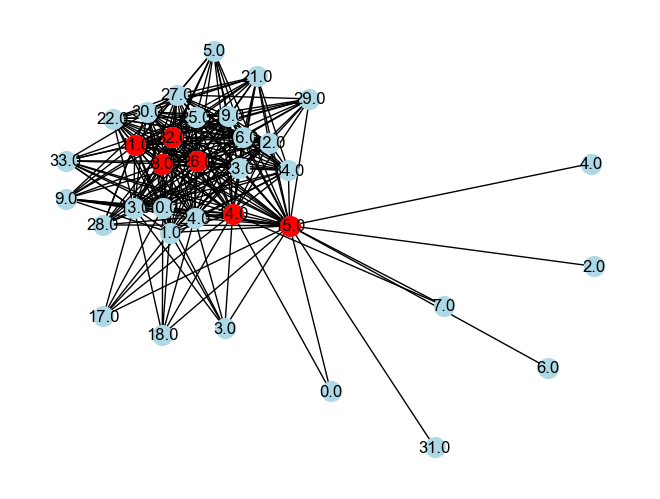

In [6]:
import networkx as nx

# Create graph from dataframe
G = nx.from_pandas_edgelist(drug_combinations, source='drug_1_id', target='drug_2_id')
degree_centrality = nx.degree_centrality(G)

pos = nx.spring_layout(G)  # Positioning of nodes
nx.draw(G, pos, with_labels=True, node_size=200, node_color='lightblue')

# Highlight nodes with high degree centrality
high_degree_nodes = [node for node, centrality in degree_centrality.items() if centrality > 0.70]
nx.draw_networkx_nodes(G, pos, nodelist=high_degree_nodes, node_size=200, node_color='red')

In [7]:
# Identify nodes with high degree centrality (top 10)
top_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

print("Top 10 nodes by degree centrality:")
for node, centrality in top_degree_centrality[:10]:
    print(f"Drug: {drug_vocab[str(node)]} ({node}), {'Degree Centrality'}: {centrality}")

Top 10 nodes by degree centrality:


KeyError: '15.0'

In [8]:
print("Top 10 nodes by lowest degree centrality:")
for node, centrality in top_degree_centrality[-10:]:
    print(f"Drug: {drug_vocab[str(node)]} ({node}), {'Degree Centrality'}: {centrality}")

Top 10 nodes by lowest degree centrality:


KeyError: '28.0'

In [9]:
from networkx.algorithms import community

# Community Detection
communities = list(community.greedy_modularity_communities(G))

print("Communities in the network:")
for i, community in enumerate(communities):
    print(f"Community {i + 1}: {list(community)}")

Communities in the network:
Community 1: [5.0, 8.0, 11.0, 12.0, 16.0, 19.0, 21.0, 22.0, 23.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 32.0, 34.0]
Community 2: [0.0, 1.0, 2.0, 3.0, 4.0, 6.0, 7.0, 9.0, 10.0, 13.0, 14.0, 15.0, 17.0, 18.0, 24.0, 31.0, 33.0]


Create multigraph

Average node degree vs max node degree vs max possible node degree

Average edge freq vs max edge freq vs max possible edge freq

Top 10 most common drugs vs Top -10 drugs

Top 10 most common drug-pairs vs Top -10 drug-pairs 

Top 10 most common drug-pairs cell lines vs -10






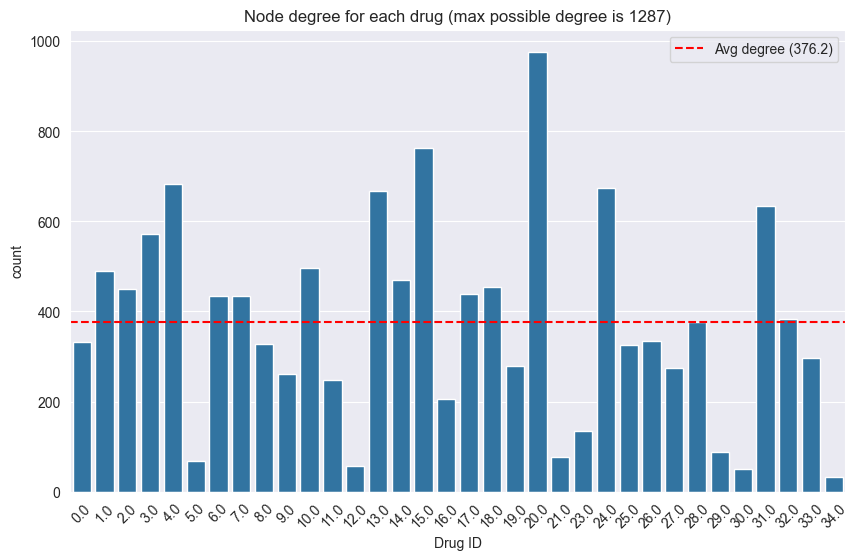

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

drug_counts = df.drug_1_id.value_counts()

plt.figure(figsize=(10, 6))
sns.countplot(df,x='drug_1_id')
plt.xticks(rotation=45)
plt.xlabel("Drug ID")
plt.axhline(y=drug_counts.mean(), color='red', linestyle='--', label='Avg degree ({})'.format(round(drug_counts.mean(),1)))
plt.title("Node degree for each drug (max possible degree is {})".format((len(unique_drugs)-1)*len(unique_cell_lines)))
plt.legend()
plt.show()

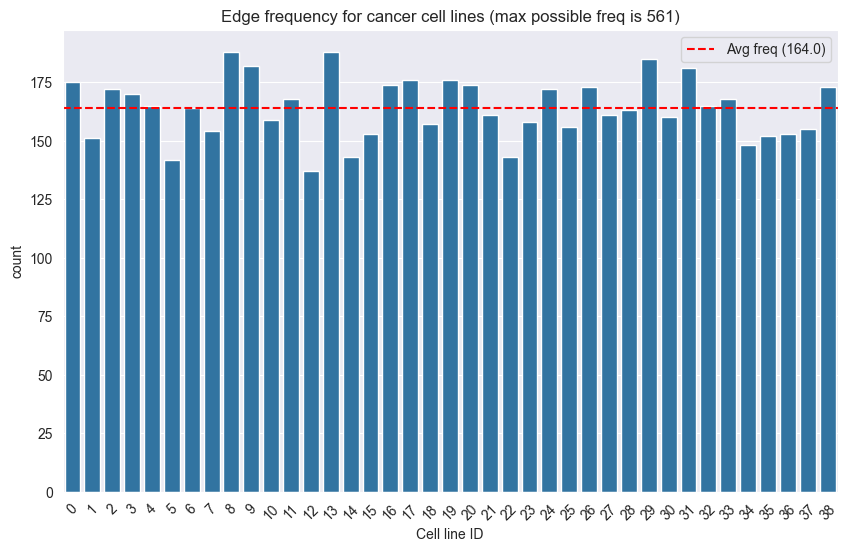

In [11]:
cell_line_counts = drug_combinations.context_id.value_counts()
plt.figure(figsize=(10, 6))
sns.countplot(drug_combinations,x='context_id')
plt.xticks(rotation=45)
plt.xlabel("Cell line ID")
plt.axhline(y=cell_line_counts.mean(), color='red', linestyle='--', label='Avg freq ({})'.format(round(cell_line_counts.mean(),1)))
plt.title("Edge frequency for cancer cell lines (max possible freq is {})".format(ncr(len(unique_drugs),2)))
plt.legend()
plt.show()

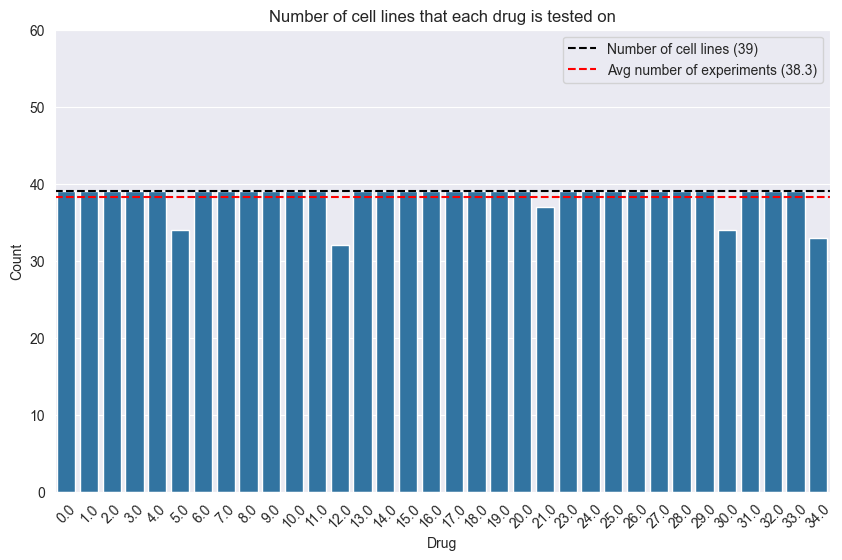

In [12]:
drug_cell_count = {drug: len(df.loc[df['drug_1_id']==drug,'context_id'].unique()) for drug in df.drug_1_id}
table_df = pd.DataFrame(list(drug_cell_count.items()), columns=['Drug', 'Count'])

plt.figure(figsize=(10, 6))
sns.barplot(x='Drug', y='Count', data=table_df)
plt.xticks(rotation=45) 
plt.ylim(0,60)
plt.axhline(y=len(unique_cell_lines), color='black', linestyle='--', label='Number of cell lines ({})'.format(len(unique_cell_lines)))
plt.axhline(y=table_df.Count.mean(), color='red', linestyle='--', label='Avg number of experiments ({})'.format(round(table_df.Count.mean(),1)))
plt.legend()
plt.title("Number of cell lines that each drug is tested on")
plt.show()

In [13]:
# Group by drug pairs and count their frequency
drug_pair_counts = drug_combinations.groupby(['drug_1_id', 'drug_2_id']).size().reset_index(name='count')

# Sort by frequency in descending order
sorted_drug_pairs = drug_pair_counts.sort_values(by='count', ascending=False)

# Select the top 10 most frequent drug pairs
top_10_drug_pairs = sorted_drug_pairs.head(10)

# Create a dictionary to store the associated cell lines for each drug pair
cell_lines_dict = {}

# List the associated cell lines for each of the top 10 drug pairs
for index, row in top_10_drug_pairs.iterrows():
    drug1 = row['drug_1_id']
    drug2 = row['drug_2_id']
    count = row['count']
    
    # Filter the data frame to get the cell lines for this drug pair
    cell_lines = df[(df['drug_1_id'] == drug1) & (df['drug_2_id'] == drug2)]['context_id'].tolist()
    
    # Store the associated cell lines in the dictionary
    cell_lines_dict[(drug1, drug2)] = cell_lines
    
    print(f"Drug Pair: ({drug_vocab[str(drug1)]} ({drug1}), {drug_vocab[str(drug2)]} ({drug2})), Frequency: {count}, Cell Lines: {cell_lines}")

KeyError: '1.0'

In [ ]:
# Check for common cell lines among the top drug pairs
common_cell_lines = set(cell_lines_dict[(top_10_drug_pairs.iloc[0]['drug_1_id'], top_10_drug_pairs.iloc[0]['drug_2_id'])])
for pair in cell_lines_dict:
    common_cell_lines.intersection_update(set(cell_lines_dict[pair]))

# If there are common cell lines, print them
if common_cell_lines:
    print("Common Cell Lines Among the Top 10 Frequent Drug Pairs:")
    for cell_line in common_cell_lines:
        print(f"{cell_line_vocab[str(cell_line)]} ({cell_line})")